<h2>Analysis for looking throgh the Interprlated data</h2>

In [1]:
import pandas as pd
import sys
sys.path.append('..')

from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer

from pathlib import Path
from scipy.constants import physical_constants, torr
from scipy.stats import iqr
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector
import lmfit

%matplotlib widget

In [2]:
run_min = 53
run_max = 169


#df = pd.read_parquet(f"/Volumes/researchEXT/O16/O16_spyral_analysis/InterpSolver/run_00{run_number}_4He.parquet")

In [3]:
workspace_path = Path("/Volumes/researchEXT/O16/no_efield/no_field_sorted_ml")
target_material_path = Path("/Users/pranjalsingh/Desktop/research_space_spyral/e20020_analysis/solver_gas_16O.json")

solver_result_path = workspace_path / "InterpSolver"
beam_events_path = workspace_path / "beam_events"


In [4]:
ejectile_z = 2
ejectile_a = 4

projectile_z = 8
projectile_a = 16

target_z = 2
target_a = 4

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [5]:
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')


ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)
print(f"Reaction: {target}({projectile}, {ejectile}){residual}")
print(f"Target material: {target_material.ugly_string}")

Reaction: 4He(16O, 4He)16O
Target material: (Gas)4He1


In [6]:
# Define parameters used for finding the cross section

downscale_factor = 1000

ic_min_val = 300.0
ic_max_val = 850.0

boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 700 # Units of torr
temperature = 293.15    # Units of Kelvin, room temperature
stoich = 1 # Stoichiometry of gas

In [25]:
proj_energy_start = 160
# Units of MeV. Initial beam energy

min_z = 0.004    # Units of meters. Minimum z value of vertex (inclusive)
max_z = 0.958    # Units of meters. Maximum z value of vertex (inclusive)

min_cm = 5.0   # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum (inclusive)
max_cm = 180.0  # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum (inclusive)

hist_en_min = -3      # Smallest allowed excitation energy in histogram (inclusive)
hist_en_max = 20   # Largest allowed excitation energy in histogram (inclusive)
hist_en_bins = 150       # Number of bins in excitation energy histogram

ang_dist_bins =  15

In [26]:
states = {}
states["gs"] = {"peak_num": 1,
                "sub_min": -0.1,
                "sub_max": 0.1,
                "cent_min": -0.07,
                "cent_max": 0.02,
                "sim_run_min": 0,
                "sim_run_max": 29}

states["6.05"] = {"peak_num": 2,
                "sub_min": 0.2,
                "sub_max": 0.4,
                "cent_min": 5.9,
                "cent_max": 6.2,
                "sim_run_min": 0,
                "sim_run_max": 29}


In [27]:
state2analyze = "gs"

In [28]:
results = {}

# Add keys for result parameters
results["polar"] = np.empty(0, float)
results["kinetic_energy"] = np.empty(0, float)
results["ex_energy"] = np.empty(0, float)
results["cm_polar"] = np.empty(0, float)
results["chisq"] = np.empty(0, float)
results["z_vert"] = np.empty(0, float)
results["brho"] = np.empty(0, float)

# Create histogram tool
grammer = Histogrammer()

In [29]:
target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})

for run in range(run_min, run_max+1):

    df = None
    path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"

    if not path.exists():
        continue
    
    df = pl.scan_parquet(path)

    df = (df.filter((pl.col("vertex_z") >= min_z) 
                    & (pl.col("vertex_z") <= max_z)
                    )
                .collect()
        )
    
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
            "px": np.zeros(len(projectile_ke)),
            "py": np.zeros(len(projectile_ke)),
            "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
            "E": projectile_ke + projectile.mass
        })
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
            "px": momentum * np.sin(polar) * np.cos(az),
            "py": momentum * np.sin(polar) * np.sin(az),
            "pz": momentum * np.cos(polar),
            "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
        })
        
    cs = df.select('redchisq').to_numpy().flatten()
    zvert=df.select('vertex_z').to_numpy().flatten()

    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    results["polar"] = np.append(results["polar"], polar)
    results["kinetic_energy"] = np.append(results["kinetic_energy"], kinetic_energy)
    results["ex_energy"] = np.append(results["ex_energy"], ex_energy)
    results["cm_polar"] = np.append(results["cm_polar"], cm_polar)
    results["chisq"] = np.append(results["chisq"], cs)
    results["z_vert"] = np.append(results["z_vert"], zvert)
    results["brho"] = np.append(results["brho"],brho)


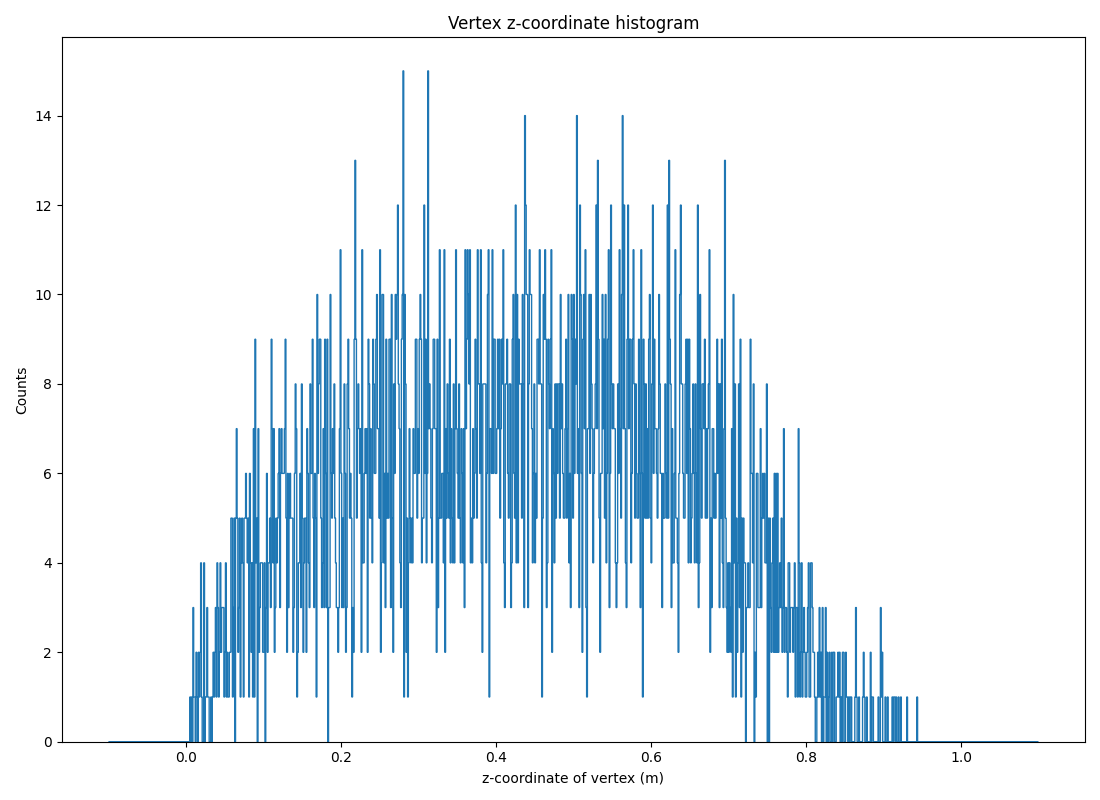

In [30]:
grammer.add_hist1d('z_vert', 1200, (-0.1, 1.1))
grammer.fill_hist1d('z_vert', results["z_vert"])
vertz = grammer.get_hist1d("z_vert")

fig, ax = plt.subplots(1,1)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title(f"Vertex z-coordinate histogram")
ax.set_xlabel("z-coordinate of vertex (m)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

In [31]:
# Calculate kinematics for residual particle in given states
proj_energy_stop = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, np.array([1.0]))[0] # Energy at far end of detector
print(f"Beam energy range: {proj_energy_start}-{proj_energy_stop} MeV")
residual_excitations = np.array([0.0,6.05])

# Do the calculation in the center of mass
cm_angle_range = np.linspace(0., np.pi, 1000)
# Calculate envelope from range of beam energies
eject_kinematics = np.zeros((len(residual_excitations), len(cm_angle_range) * 2, 2))

# Upper limit (maximum beam energy)
beam_vec_max = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_start * (proj_energy_start + 2.0 * projectile.mass))],
    "E": [proj_energy_start + projectile.mass]
})
parent_max = target_vector + beam_vec_max
parent_cm_max = parent_max.boostCM_of(parent_max)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_max = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_max.E**2.0) / (2.0 * parent_cm_max.E)
    eject_p_cm_max = np.sqrt(eject_e_cm_max**2.0 - ejectile.mass**2.0)
    eject_vec_cms_max = vector.array({
        "px": eject_p_cm_max * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_max * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_max)
    })
    eject_vec_lab_max = eject_vec_cms_max.boost(parent_max)
    eject_kinematics[idx, :len(cm_angle_range), 0] = eject_vec_lab_max.theta
    eject_kinematics[idx, :len(cm_angle_range), 1] = eject_vec_lab_max.E - ejectile.mass

# Lower limit (minimum beam energy)
beam_vec_min = vector.array({
    "px": [0.0],
    "py": [0.0],
    "pz": [np.sqrt(proj_energy_stop * (proj_energy_stop + 2.0 * projectile.mass))],
    "E": [proj_energy_stop + projectile.mass]
})
parent_min = target_vector + beam_vec_min
parent_cm_min = parent_min.boostCM_of(parent_min)
for idx, ex in enumerate(residual_excitations):
    eject_e_cm_min = (ejectile.mass**2.0 - (residual.mass + ex)**2.0 + parent_cm_min.E**2.0) / (2.0 * parent_cm_min.E)
    eject_p_cm_min = np.sqrt(eject_e_cm_min**2.0 - ejectile.mass**2.0)
    eject_vec_cms_min = vector.array({
        "px": eject_p_cm_min * np.sin(cm_angle_range),
        "py": np.zeros(len(cm_angle_range)),
        "pz": eject_p_cm_min * np.cos(cm_angle_range),
        "E": np.full(len(cm_angle_range), eject_e_cm_min)
    })
    eject_vec_lab_min = eject_vec_cms_min.boost(parent_min)
    # Note that lower limit is "flipped". We plot the band as a polygon, so need to continue from large lab angles to small lab angles
    eject_kinematics[idx, len(cm_angle_range):, 0] = np.flip(eject_vec_lab_min.theta)
    eject_kinematics[idx, len(cm_angle_range):, 1] = np.flip(eject_vec_lab_min.E - ejectile.mass)

Beam energy range: 160-109.50492724716275 MeV


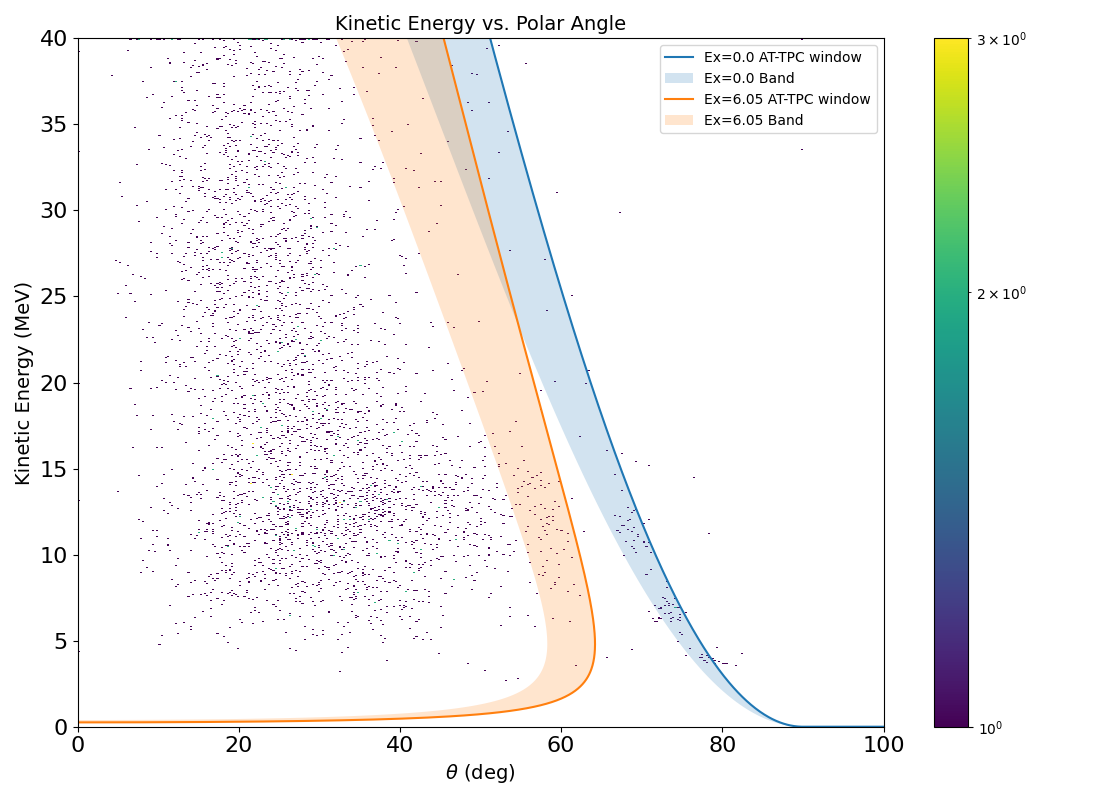

In [32]:
# Plot kinematics from data and compare with theoretical kinematics
grammer.add_hist2d('ke_theta', (700, 900), ((0.0, 180.0), (0.0, 40.0)))
grammer.fill_hist2d('ke_theta', np.rad2deg(results["polar"]), results["kinetic_energy"])
ke_theta = grammer.get_hist2d("ke_theta")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(ke_theta.x_bins, ke_theta.y_bins, ke_theta.counts, norm="log")
ax.set_title("Kinetic Energy vs. Polar Angle",fontsize=14)
ax.set_xlabel(r"$\theta$ (deg)",fontsize=14)
ax.set_ylabel("Kinetic Energy (MeV)",fontsize=14)
fig.colorbar(mesh, ax=ax)
for idx, ex in enumerate(residual_excitations):
    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]), eject_kinematics[idx, :len(cm_angle_range), 1], label=f"Ex={ex:02} AT-TPC window")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), eject_kinematics[idx, :, 1], label=f"Ex={ex:02} Band", alpha=0.2)
ax.legend()
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
ax.tick_params(axis='both', labelsize=16)
# plt.suptitle(f"Lab Energy = {proj_energy_start}")
plt.xlim(0,100)
plt.ylim(0,40)
fig.tight_layout()

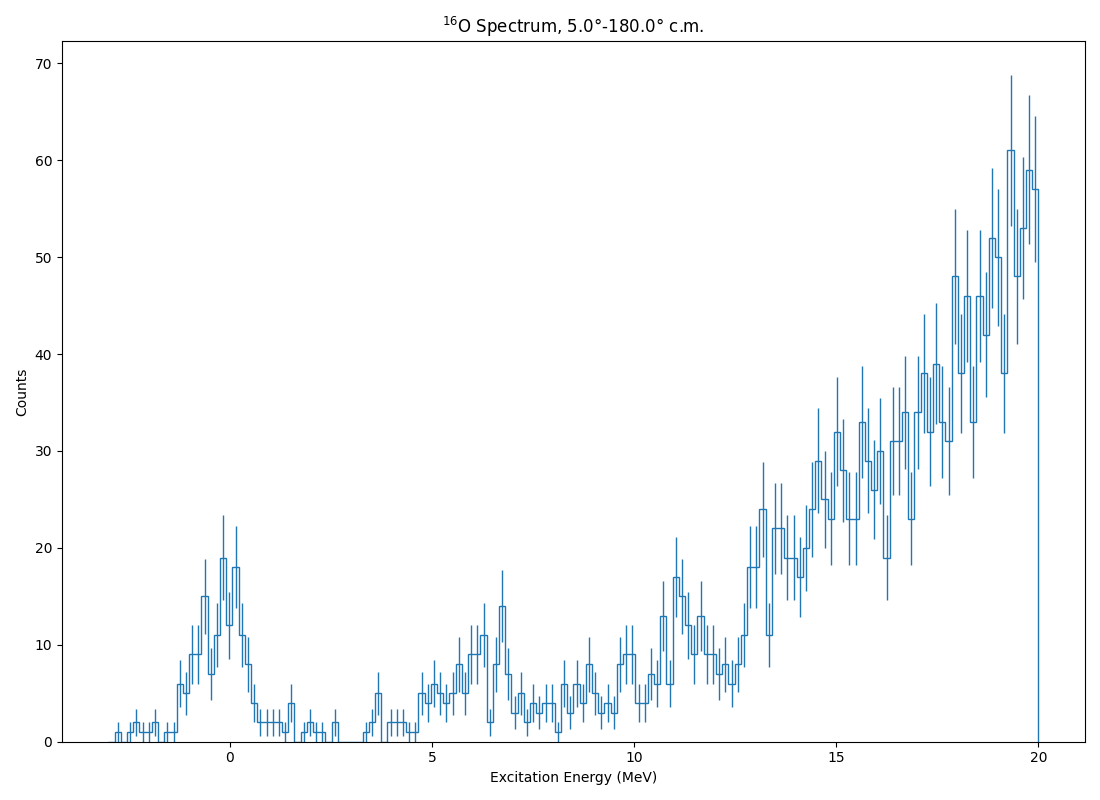

In [33]:
# Plot excitation energy spectrum

# Gate excitation spectrum on CM angle
mask_cm = (np.deg2rad(min_cm) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(max_cm))    # Make note of inequalites for binning!
ex_energy_gated = results["ex_energy"][mask_cm]

grammer.add_hist1d("ex_energy",hist_en_bins, (hist_en_min, hist_en_max))
grammer.fill_hist1d("ex_energy", ex_energy_gated)

ex_hist = grammer.get_hist1d("ex_energy")
fig, ax = plt.subplots(1,1)
ax.stairs(ex_hist.counts, edges=ex_hist.bins)
ax.errorbar(ex_hist.bins[:-1] + ex_hist.bin_width/2, ex_hist.counts, yerr=np.sqrt(ex_hist.counts), fmt="o", markersize=0, color="tab:blue", linewidth=1)
ax.set_title(f"{residual.get_latex_rep()} Spectrum, {min_cm}\N{DEGREE SIGN}-{max_cm}\N{DEGREE SIGN} c.m.")
ax.set_xlabel("Excitation Energy (MeV)")
ax.set_ylabel("Counts")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)
fig.tight_layout()

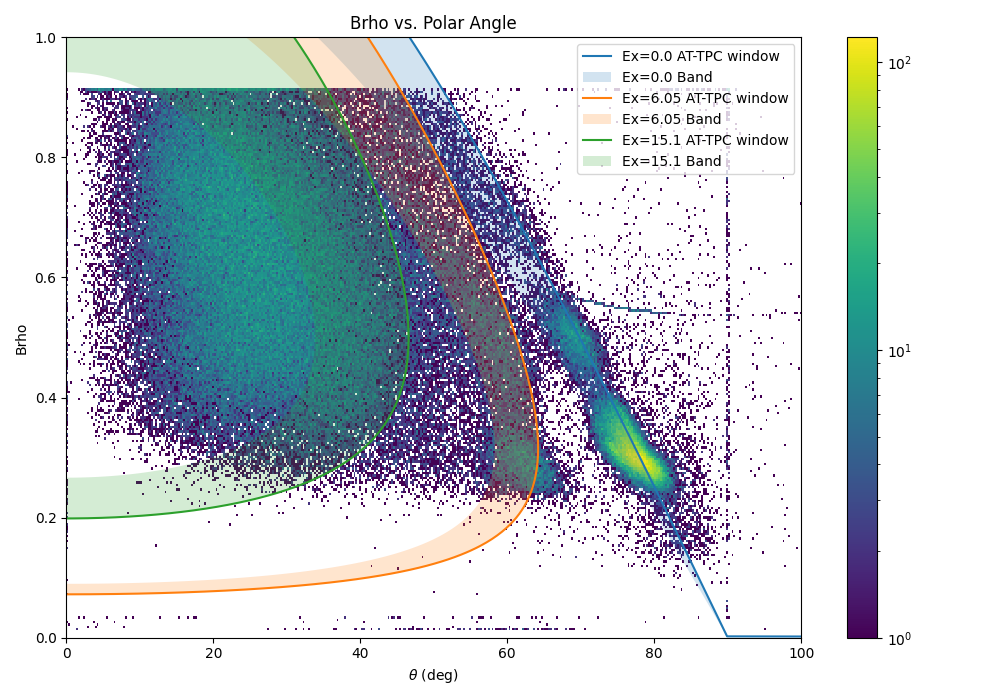

In [16]:
grammer.add_hist2d('brho_theta', (700, 800), ((0.0, 180.0), (-0.1, 3.0)))
grammer.fill_hist2d('brho_theta', np.rad2deg(results["polar"]), results["brho"])



brho_theta = grammer.get_hist2d("brho_theta")

fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(brho_theta.x_bins, brho_theta.y_bins, brho_theta.counts, norm="log")
for idx, ex in enumerate(residual_excitations):
    momentum_cm = np.sqrt((eject_kinematics[idx, :len(cm_angle_range), 1] + ejectile.mass)**2 - (ejectile.mass)**2)
    brho_cm = momentum_cm/(float(ejectile.Z) * QBRHO_2_P)

    momentum_dist = np.sqrt((eject_kinematics[idx, :, 1] + ejectile.mass)**2 - (ejectile.mass)**2)
    brho_dist = momentum_dist/(float(ejectile.Z) * QBRHO_2_P)

    ax.plot(np.rad2deg(eject_kinematics[idx, :len(cm_angle_range), 0]),brho_cm, label=f"Ex={ex:02} AT-TPC window")
    # Fill idea thanks to D. Ramirez
    ax.fill(np.rad2deg(eject_kinematics[idx, :, 0]), brho_dist, label=f"Ex={ex:02} Band", alpha=0.2)

ax.set_title("Brho vs. Polar Angle")
ax.set_xlabel(r"$\theta$ (deg)")
ax.set_ylabel("Brho")
fig.colorbar(mesh, ax=ax)

ax.legend()
fig.set_figheight(7.0)
fig.set_figwidth(10.0)
# plt.suptitle(f"Lab Energy = {proj_energy_start}")
plt.xlim(0,100)
plt.ylim(0,1)
fig.tight_layout()

In [17]:
# Fit excitation spectrum peaks for each angular bin

# Create dictionary to store results of excitation background removal
sub_fits = {}

# Make array of edges of angular cuts
ang_bins = np.linspace(min_cm, max_cm, ang_dist_bins+1)

for idx in range(len(ang_bins) - 1): #len(ang_bins) - 1
    low_edge = ang_bins[idx]
    high_edge = ang_bins[idx+1]

    # Gate excitation spectrum on CM angle
    if idx != (len(ang_bins) - 1):
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] < np.deg2rad(high_edge))    # Make note of inequalites for binning!
    else:
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(high_edge))    # Make note of inequalites for binning!

    ex_energy_gated = results["ex_energy"][mask]

    # Make and fill histogram
    title = f"ex_energy_{low_edge}-{high_edge}"
    grammer.add_hist1d(title, hist_en_bins, (hist_en_min, hist_en_max))
    grammer.fill_hist1d(title, ex_energy_gated)
    sub_ex_hist = grammer.get_hist1d(title)

    # Fit histogram
    peak1 = lmfit.models.GaussianModel (prefix="peak1_")
    peak1_bins, peak1_counts = sub_ex_hist.get_subrange((states["gs"]["sub_min"], states["gs"]["sub_max"]))
    peak1_bins += 0.5 * sub_ex_hist.bin_width
    peak1_weights = np.sqrt(peak1_counts)
    peak1_weights = np.divide(1, peak1_weights, out=np.zeros_like(peak1_weights), where=peak1_weights!=0.0)
    pars = peak1.guess(x=peak1_bins, data=peak1_counts, weights=peak1_weights)
    pars["peak1_amplitude"].min = 0.0
    pars["peak1_center"].min = -1.0
    pars["peak1_center"].max = 0.7
    pars["peak1_sigma"].min = 0.0
    pars["peak1_sigma"].max = 1.5
    
    
    peak2 = lmfit.models.GaussianModel(prefix="peak2_")
    peak2_bins, peak2_counts = sub_ex_hist.get_subrange((states["6.05"]["sub_min"], states["6.05"]["sub_max"]))
    peak2_bins += 0.5 * sub_ex_hist.bin_width
    peak2_weights = np.sqrt(peak2_counts)
    peak2_weights = np.divide(1, peak2_weights, out=np.zeros_like(peak2_weights), where=peak2_weights!=0.0)
    pars.update(peak2.guess(x=peak2_bins, data=peak2_counts, weights=peak2_weights))
    pars["peak2_amplitude"].min = 0.01
    pars["peak2_center"].min = 5.2
    pars["peak2_center"].max = 6.2
    pars["peak2_sigma"].min = 0.0
    pars["peak2_sigma"].max = 0.9

    # bkgd = lmfit.models.StepModel(prefix="bkgd_")
    # bkgd_bins, bkgd_counts = sub_ex_hist.get_subrange((3.8, 4.3))
    # bkgd_bins += 0.5 * sub_ex_hist.bin_width
    # bkgd_weights = np.sqrt(bkgd_counts)
    # bkgd_weights = np.divide(1, bkgd_weights, out=np.zeros_like(bkgd_weights), where=bkgd_weights!=0.0)
    # pars.update(bkgd.guess(x=bkgd_bins, data=bkgd_counts, weights=bkgd_weights))
    # pars["bkgd_amplitude"].min = 0.0
    # pars["bkgd_center"].min = 3.6
    # pars["bkgd_center"].max = 4.3
    # pars["bkgd_sigma"].set(expr="peak1_sigma", vary=False)

    total_fit = peak1 + peak2 
    total_bins = sub_ex_hist.bins[:-1] + sub_ex_hist.bin_width/2
    total_counts = sub_ex_hist.counts
    total_weights = np.sqrt(total_counts)
    total_weights = np.divide(1, total_weights, out=np.zeros_like(total_weights), where=total_weights!=0.0)
    total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)

    # Store total fit result
    sub_fits[title] = total_result


In [18]:
print(sub_fits)

{'ex_energy_18.0-20.0': <lmfit.model.ModelResult object at 0x31ef53e90>, 'ex_energy_20.0-22.0': <lmfit.model.ModelResult object at 0x32acdd090>, 'ex_energy_22.0-24.0': <lmfit.model.ModelResult object at 0x32ac65090>, 'ex_energy_24.0-26.0': <lmfit.model.ModelResult object at 0x32ac37690>, 'ex_energy_26.0-28.0': <lmfit.model.ModelResult object at 0x32ac4a0d0>, 'ex_energy_28.0-30.0': <lmfit.model.ModelResult object at 0x17b1d2c50>, 'ex_energy_30.0-32.0': <lmfit.model.ModelResult object at 0x32ac3a310>, 'ex_energy_32.0-34.0': <lmfit.model.ModelResult object at 0x332bc7910>, 'ex_energy_34.0-36.0': <lmfit.model.ModelResult object at 0x332bdff90>, 'ex_energy_36.0-38.0': <lmfit.model.ModelResult object at 0x32acf6990>, 'ex_energy_38.0-40.0': <lmfit.model.ModelResult object at 0x32ac7f350>, 'ex_energy_40.0-42.0': <lmfit.model.ModelResult object at 0x32ac3eb50>, 'ex_energy_42.0-44.0': <lmfit.model.ModelResult object at 0x332c06b50>, 'ex_energy_44.0-46.0': <lmfit.model.ModelResult object at 0x332

In [19]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("/Users/pranjalsingh/Desktop/research_space_spyral/O16_alpha_elastic.pdf") as pdf:
    for keys in sub_fits.keys():

        idx += 1
        low_edge = 20.0
        high_edge = 22.0
        title = keys
        title_plot = keys.removeprefix("ex_energy_")
        # title_plot = f"ex_energy_{low_edge}-{high_edge}"

        # Get results of fit
        sub_fit_result = sub_fits[title]
        comps = sub_fit_result.eval_components()

        # print(sub_fit_result.params["peak1_center"].value)

        # Plot result
        fig, ax = plt.subplots(1,1)
        sub_ex_hist = grammer.get_hist1d(title)
        ax.stairs(sub_ex_hist.counts, edges=sub_ex_hist.bins, label="Spectrum")
        # ax.plot(total_bins, sub_fit_result.best_fit, label="Total Fit")
        ax.plot(total_bins, comps["peak1_"], label="peak1")
        ax.plot(total_bins, comps["peak2_"], label="peak2")
        # ax.plot(total_bins, comps["bkgd_"], label="bkgd")
        ax.stairs(comps["peak1_"], edges=sub_ex_hist.bins)
        ax.stairs(comps["peak2_"], edges=sub_ex_hist.bins)
        plt.axvline(x=sub_fit_result.params["peak1_center"].value, color="black",linestyle="--",label= f"Center: {sub_fit_result.params['peak1_center'].value:.2f} | Sigma: {sub_fit_result.params['peak1_sigma'].value:.2f}")
        plt.axvline(x=sub_fit_result.params["peak2_center"].value, color="black",linestyle="--",label= f"Center: {sub_fit_result.params['peak2_center'].value:.2f} | Sigma: {sub_fit_result.params['peak2_sigma'].value:.2f}")
        ax.set_title(f"{residual.get_latex_rep()} Spectrum, {title_plot}\N{DEGREE SIGN} c.m.")
        ax.set_xlabel("Excitation Energy (MeV)")
        ax.set_ylabel("Counts")
        ax.legend()
        fig.set_figheight(8.0)
        fig.set_figwidth(11.0)
        fig.tight_layout()
        
        pdf.savefig()


In [20]:

cm_counts = np.zeros(ang_dist_bins)
cm_counts_err = np.zeros(ang_dist_bins)

# state_id = states[state2analyze]["peak_num"]
state_id = 2
for idx, fit in enumerate(sub_fits.items()):
    comps_fit = fit[1].eval_components()
    state_fit = comps_fit[f"peak{state_id}_"]
    cm_counts[idx] = np.sum(state_fit)


    # If fit is bad, uncertainties cannot be estimated
    try:
        fit[1].eval_uncertainty()
        fit_err = fit[1].dely_comps
        cm_counts_err[idx] = np.sqrt(np.sum(fit_err[f"peak{state_id}_"]**2))
    except:
        print(f"{fit[0]} failed")

grammer.add_hist1d("cm_polar", ang_dist_bins, (min_cm, max_cm))
cm_hist = grammer.get_hist1d("cm_polar")
cm_hist.counts = cm_counts

In [21]:
length = 1    # Units of meters
beam_counts = 100000000
nuclei_areal_density = pressure * torr_2_pascal * length / boltzmann / temperature * stoich * 1.0e-31 # Units of target nuclei / millibarns

# Without efficiency correction
xs = cm_hist.counts  / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)   # Units of millibarns / steradians
xs_err = np.sqrt(cm_hist.counts) / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)

In [22]:
print(len(cm_hist.bins[:-1]+cm_hist.bin_width/2))
print(xs_err)
print(100000000/100)

15
[0.64198936 1.35820253 1.58498391 1.52661083 1.37461886 1.21104952
 0.98556963 0.85345211 0.71653068 0.74880361 0.72086502 0.72154324
 0.69751414 0.65428412 0.68315309]
1000000.0


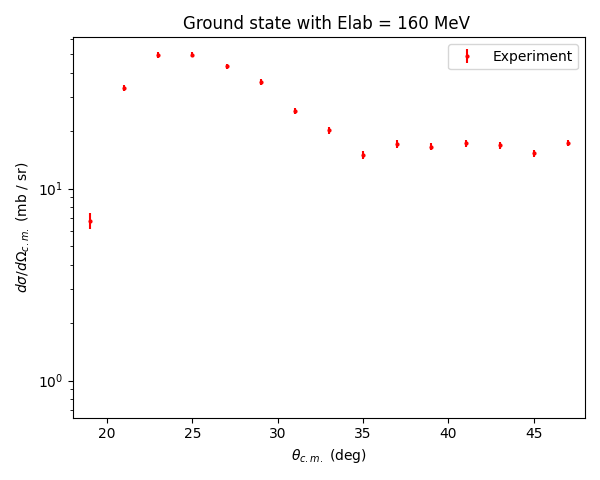

In [23]:
import pandas as pd

# file_path = "/Users/pranjalsingh/Desktop/research_space_spyral/e20020_analysis/Ptolemy/DWBA_gs.Xsec.txt"
# df = pd.read_csv(file_path, sep='\s+', skiprows=1) 
# print(df.columns)
# df

# angle = df['Angel'].to_numpy().astype(float)
# xsec = df['ELab=40.00(a+16O)ss'].to_numpy().astype(float)

fig, ax = plt.subplots(1, 1)
# ax.scatter(angle[10:], xsec[10:],label = "Su and Han, 2015",s=5)
ax.set_yscale("log")

ax.errorbar(cm_hist.bins[:-1]+cm_hist.bin_width/2, xs, yerr=xs_err, c="red",fmt='o', markersize=2,label="Experiment")

ax.set_title(f"Ground state with Elab = {proj_energy_start} MeV ")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")

plt.xlim(min_cm, max_cm)
# plt.ylim(0,5e2)
ax.legend()
fig.set_figwidth(8.0)
fig.set_figwidth(6.0)
fig.tight_layout()


/var/folders/5q/ngq_6gg50c35p7kqrqgnwmzw0000gs/T/ipykernel_80387/1402964513.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


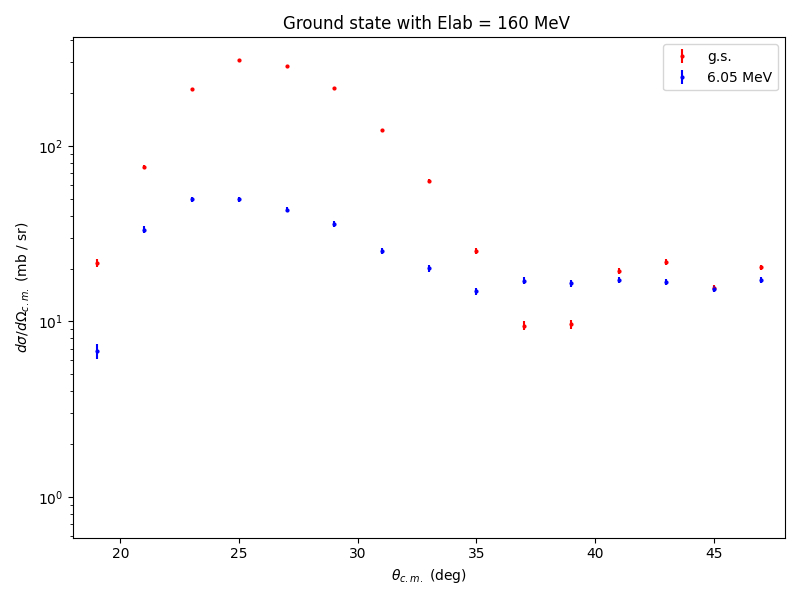

In [24]:
fig, ax = plt.subplots(1, 1)
ax.set_yscale("log")

colors = ["red", "blue"]  # one color per state
labels = ["g.s.", "6.05 MeV"]


for i, state_id in enumerate([1, 2]):   # loop over states
    cm_counts = np.zeros(ang_dist_bins)
    cm_counts_err = np.zeros(ang_dist_bins)

    for idx, fit in enumerate(sub_fits.items()):
        comps_fit = fit[1].eval_components()
        state_fit = comps_fit[f"peak{state_id}_"]
        cm_counts[idx] = np.sum(state_fit)

        try:
            fit[1].eval_uncertainty()
            fit_err = fit[1].dely_comps
            cm_counts_err[idx] = np.sqrt(np.sum(fit_err[f"peak{state_id}_"]**2))
        except:
            print(f"{fit[0]} failed")

    # Histogram container
    grammer.add_hist1d(f"cm_polar_{state_id}", ang_dist_bins, (min_cm, max_cm))
    cm_hist = grammer.get_hist1d(f"cm_polar_{state_id}")
    cm_hist.counts = cm_counts
    
    # Physics scaling
    length = 1    # m
    beam_counts = 100000000
    nuclei_areal_density = (
        pressure * torr_2_pascal * length / boltzmann / temperature * stoich * 1.0e-31
    )

    xs = cm_hist.counts / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (
        -2 * np.pi * beam_counts * nuclei_areal_density
    )
    xs_err = np.sqrt(cm_hist.counts) / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (
        -2 * np.pi * beam_counts * nuclei_areal_density
    )

    # Plot both on the same axes
    ax.errorbar(
        cm_hist.bins[:-1] + cm_hist.bin_width / 2,
        xs,
        yerr=xs_err,
        c=colors[i],
        fmt="o",
        markersize=2,
        label=labels[i],
    )

ax.set_title(f"Ground state with Elab = {proj_energy_start} MeV ")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")

plt.xlim(min_cm, max_cm)
ax.legend()
fig.set_figwidth(8.0)
fig.set_figheight(6.0)
fig.tight_layout()
plt.show()
